In [ ]:
# import packages and libraries
import numpy as np 
import pandas as pd 
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# remove hidden checkpoints files
!rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
batch_size = 16 # batch size
img_height = 200 # image height
img_width = 200 # image width

In [ ]:
# loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Preprocessed', # directory path
    validation_split = 0.2, # split ratio
    subset = "training", # training subset
    seed = 42, # set seed location
    image_size = (img_height, img_width), # image size of height and width
    batch_size = batch_size # batch size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [ ]:
# loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Preprocessed', # directory path
    validation_split = 0.2, # split ratio
    subset = "validation", # validation subset
    seed = 42, # set seed location
    image_size = (img_height, img_width), # image size of height and width
    batch_size = batch_size # batch size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [ ]:
# target class names
class_names = training_ds.class_names
print(class_names)

['Mask', 'NoMask']


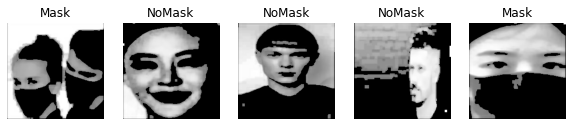

In [ ]:
# show sample images from training set
image_batch, label_batch = next(iter(training_ds))
plt.figure(figsize=(10, 10)) # figure size
for i in range(5): # for 5 images
  ax = plt.subplot(1, 5, i + 1) # 5 images in 1 row
  plt.imshow(image_batch[i].numpy().astype("uint8")) # show images
  label = label_batch[i] # label of each image
  plt.title(class_names[label]) # title of each 
  plt.axis("off")

In [ ]:
# configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# cache() keeps images in memory to ensure dataset does not become a bottleneck 
  # while training the model
# prefetch() overlaps data preprocessing and model execution while training
training_ds = training_ds.cache().prefetch(buffer_size = AUTOTUNE) # for training
testing_ds = testing_ds.cache().prefetch(buffer_size = AUTOTUNE) # for testing

In [ ]:
# CNN model
MyCnn = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255), 
  layers.Conv2D(32, 3, activation = 'relu'),  # convolution layers
  layers.MaxPooling2D(), # maximum pooling layers
  layers.Conv2D(32, 3, activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation = 'relu'),
  layers.MaxPooling2D(),
  layers.GlobalAveragePooling2D(),
  layers.Dense(512, activation = 'relu'), # dense layer
  layers.Dense(2, activation =  'softmax') # soft-max layer
])

In [ ]:
# CNN with adam optimiser, sparse categorical crossentropy loss, and accuracy metrics
MyCnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# fit model to training and validation data, with 20 epochs
!pip install h5py
model_saved = MyCnn.fit(training_ds, validation_data= testing_ds, epochs = 20)

Epoch 1/20
570/570 [==============================] - 1769s 3s/step - loss: 0.5891 - accuracy: 0.6884 - val_loss: 0.6069 - val_accuracy: 0.6977
Epoch 2/20
570/570 [==============================] - 467s 819ms/step - loss: 0.5398 - accuracy: 0.7242 - val_loss: 0.5751 - val_accuracy: 0.7192
Epoch 3/20
570/570 [==============================] - 465s 815ms/step - loss: 0.5123 - accuracy: 0.7397 - val_loss: 0.5029 - val_accuracy: 0.7513
Epoch 4/20
570/570 [==============================] - 465s 816ms/step - loss: 0.4723 - accuracy: 0.7650 - val_loss: 0.5109 - val_accuracy: 0.7482
Epoch 5/20
570/570 [==============================] - 467s 819ms/step - loss: 0.4280 - accuracy: 0.7846 - val_loss: 0.4423 - val_accuracy: 0.7873
Epoch 6/20
570/570 [==============================] - 468s 821ms/step - loss: 0.3823 - accuracy: 0.8134 - val_loss: 0.4012 - val_accuracy: 0.8159
Epoch 7/20
570/570 [==============================] - 478s 839ms/step - loss: 0.3390 - accuracy: 0.8401 - val_loss: 0.3829 - v

In [ ]:
# CNN evaluate test accuracy and loss in the 
test_loss, test_accuracy = MyCnn.evaluate(testing_ds, steps= 10)

10/10 [==============================] - 2s 210ms/step - loss: 0.2560 - accuracy: 0.9125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Unrecognized location 'middle right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if sys.path[0] == '':


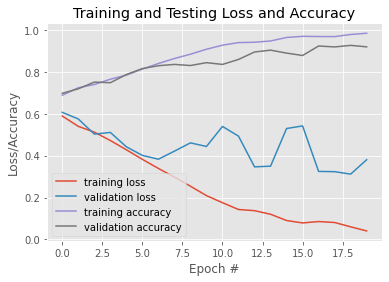

In [ ]:
# compare Training and Testing  Losses and Accuracies
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), model_saved.history['loss'], 
         label = 'training loss') # training loss
plt.plot(np.arange(0, N), model_saved.history['val_loss'], 
         label = 'validation loss') # testing loss
plt.plot(np.arange(0, N), model_saved.history['accuracy'], 
         label = 'training accuracy') # training accuracy
plt.plot(np.arange(0, N), model_saved.history['val_accuracy'], 
         label = 'validation accuracy') # testing accuracy
plt.title("Training and Testing Loss and Accuracy") # title of comparative line graph
plt.xlabel("Epoch #") # x axis label
plt.ylabel("Loss/Accuracy") # y axis label
plt.legend(loc = "middle right") # legend

In [ ]:
# save model to /content/dnn path
MyCnn.save(os.path.join("./dnn/","mpg_model.h5"))